In [1]:
from pycoingecko import CoinGeckoAPI
from datetime import datetime, timezone, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

cg = CoinGeckoAPI()

Timestamp returned by this API are in UTC Timezone.

In [241]:
I = int((datetime(2021,2,16)-datetime(2018, 5, 25)).days/90)


In [242]:
# dt = datetime(2021, 2, 10)
# from_timestamp = dt.replace(tzinfo=timezone.utc).timestamp()

prices_pd_arr = []
dt = datetime(2018, 5, 25)
for i in range(I):
    from_timestamp = dt.replace(tzinfo=timezone.utc).timestamp()

    dt = dt+timedelta(days=+90)
    to_timestamp = dt.replace(tzinfo=timezone.utc).timestamp()

    prices = cg.get_coin_market_chart_range_by_id(id='bitcoin',
                                         vs_currency='USD',
                                         from_timestamp = from_timestamp,
                                         to_timestamp= to_timestamp)
    prices_pd = pd.DataFrame(prices['prices'])
    prices_pd_arr.append(prices_pd)


KeyboardInterrupt: 

In [362]:
last_timestamp = datetime(2021,2,17)
last_timestamp = last_timestamp.replace(tzinfo=timezone.utc).timestamp()
prices = cg.get_coin_market_chart_range_by_id(id='bitcoin',
                                     vs_currency='USD',
                                     from_timestamp = to_timestamp,
                                     to_timestamp= last_timestamp)
prices_pd = pd.DataFrame(prices['prices'])
prices_pd_arr.append(prices_pd)

In [454]:
results = pd.concat(prices_pd_arr)
results = results.drop_duplicates()
results.columns = ['UTC_time', 'bitcoin price']

In [ ]:
results.loc[:,'UTC_time'] = pd.to_datetime(results.loc[:,'UTC_time']*1000000)
results.loc[:,'berlin_time'] = results.loc[:,'UTC_time'].apply(lambda x: x+timedelta(hours=1))
results.loc[:,'berlin_time_date'] = results.loc[:,'UTC_time'].apply(lambda x: x.date())
results.loc[:,'berlin_time_hour'] = results.berlin_time.apply(lambda x:x.hour)
results.loc[:,'berlin_time_min'] = results.berlin_time.apply(lambda x:x.minute)
results.reset_index(drop=True, inplace=True)

In [468]:
results.to_csv('bitcoin_hourly_price_coingecko_raw.csv')

In [4]:
def time_diff(x, target_hour):
    y = x.year
    m = x.month
    d = x.day 
    return np.abs((x - datetime(y,m,d,target_hour)).total_seconds())

In [5]:
results.loc[:,'D'] = results.berlin_time.apply(lambda x: time_diff(x, 23))

AttributeError: 'str' object has no attribute 'year'

In [238]:
results.loc[:,'D'] = results.berlin_time.apply(lambda x: time_diff(x, 23))

AttributeError: 'str' object has no attribute 'year'

In [2]:
results = pd.read_csv('../data/btc future and reference rate/bitcoin_hourly_price_coingecko_raw.csv')

In [7]:
date_arr = results.berlin_time_date.unique()

closest_to_23 = []

for date in date_arr:
    _id = results.berlin_time_date==date
    closest_to_23.append(np.argmin(results.loc[_id,'D']))

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


In [8]:
bitcoin_price = results.iloc[closest_to_23,:].loc[:,['berlin_time_date', 'bitcoin price']]

In [9]:
bitcoin_price.reset_index(drop=True, inplace=True)

In [10]:
future = pd.read_excel('../data/btc future and reference rate/btc_future.xlsx')
future = future.dropna()

In [11]:
future.Date = pd.to_datetime(future.Date)

In [12]:
bitcoin_price.loc[:,'Date']=pd.to_datetime(bitcoin_price.berlin_time_date)

In [14]:
df = bitcoin_price.merge(future, how='inner', on='Date').loc[:,['Date', 'bitcoin price', 'Close']]
df.dropna(inplace=True)
df.sort_values('Date', ascending= False, inplace=True)
df.reset_index(drop=True, inplace=True)

In [50]:
df.loc[:,'log return bitcoin'] = np.log(df.iloc[:,1]/df.iloc[:,1].shift(-1))

In [51]:
df.loc[:,'log return future'] = np.log(df.iloc[:,2]/df.iloc[:,2].shift(-1))


In [52]:
df.dropna(inplace=True)

In [53]:
df.to_csv('../data/btc future and reference rate/coingecko_future.csv')

In [54]:
df.head()

,Date,bitcoin price,Close,log return bitoin,log return future,log return bitcoin
0,2021-02-03,37266.377988,37790.0,0.045299,0.033774,0.045299
1,2021-02-02,35615.923864,36535.0,0.059664,0.064146,0.059664
2,2021-02-01,33553.086495,34265.0,-0.041523,-0.026353,-0.041523
3,2021-01-29,34975.625836,35180.0,0.052253,0.061398,0.052253
4,2021-01-28,33194.978393,33085.0,0.067181,0.036317,0.067181


In [55]:
import os
filename = 'coingecko_future_v5'
path = "../processed_data/"+ filename+"/"
if not os.path.exists(path):
    os.mkdir(path)
    os.mkdir(path+'train/')
    os.mkdir(path+'test/')
    

In [56]:
train_size = 300
test_size = 100 
step_size = 5 

n = int(np.floor((len(df)-train_size-test_size)/step_size))

train_set = []
test_set = []

for i in range(n):
    data = df.iloc[(i*step_size):((i)*step_size)+train_size+test_size]
    test = data.iloc[:test_size,]
    train = data.iloc[test_size:,]
    train_set.append(train)
    test_set.append(test)

for i in range(len(train_set)):
    train_set[i].to_csv(path+'train/'+str(i)+".csv")
    test_set[i].to_csv(path+'test/'+str(i)+".csv")

In [49]:
test_set[-2].tail()

,Date,bitcoin price,Close,log return bitoin,log return future
360,2019-08-29,9516.610158,9570.0,-0.035592,-0.018121
361,2019-08-28,9861.427773,9745.0,-0.037513,-0.055390
362,2019-08-27,10238.384592,10300.0,0.004348,-0.016370
363,2019-08-26,10193.962003,10470.0,-0.028206,-0.007612
364,2019-08-23,10485.584088,10550.0,0.036332,0.026412


In [48]:
train_set[-2].head()

,Date,bitcoin price,Close,log return bitoin,log return future
365,2019-08-22,10111.460266,10275.0,0.002106,0.006346
366,2019-08-21,10090.188837,10210.0,-0.068070,-0.060337
367,2019-08-20,10800.939830,10845.0,0.008204,0.001384
368,2019-08-19,10712.689131,10830.0,0.026051,0.019110
369,2019-08-16,10437.216342,10625.0,0.009652,0.036908


https://www.coingecko.com/en/methodology

1. Price (Cryptoasset)
The price of a cryptoasset is calculated based on the pairings available and collected by CoinGecko from the various exchanges for a particular cryptoasset. The price shown on CoinGecko for a particular cryptoasset is calculated using a global volume-weighted average price formula.
Example 1 (Different fiat pairings)

Using Bitcoin (BTC) as an example, and assuming we only track two exchanges, A and B which trades in USD and JPY:

Exchange A: BTC/USD = USD 1,000 / BTC @ 15,000 BTC Trading Volume (rolling 24 hours)
Exchange B: BTC/JPY = JPY 109,000 / BTC @ 10,000 BTC Trading Volume (rolling 24 hours)
CoinGecko will first convert JPY to USD using FX rates provided by OpenExchangeRates. Assuming USD 1 = JPY 110, this will mean:

Exchange B: BTC/JPY = JPY 109,000 / BTC ≈ USD 990 / BTC

CoinGecko will then calculate the global volume-weighted average price. In this case, it will be:

CoinGecko BTC Price (USD)
= [Volume % * USD Price] + [Volume % * Converted USD Price]
= [ 15,000 / (15,000 + 10,000) ] * USD 1,000 + [ 10,000 / (15,000 + 10,000) ] * USD 990
= 0.6 * USD 1,000 + 0.4 * USD 990
= USD 996
Example 2 (Fiat & other crypto pairings)

Using Ethereum (ETH) as an example, and assuming we only track two exchanges, A and B which trades in USD and BTC:
Exchange A: ETH/USD = USD 200 / ETH @ 30,000 ETH Trading Volume (rolling 24 hours)
Exchange B: ETH/BTC = ₿ 0.20000000 / ETH @ 20,000 ETH Trading Volume (rolling 24 hours)
CoinGecko will first convert the ETH/BTC price to a USD price using the CoinGecko BTC Price derived above. Assuming 1 BTC = USD 996, this will mean:
Exchange B: ETH/BTC = ₿ 0.20000000 / ETH ≈ USD 199.2 / ETH

CoinGecko will then calculate the global volume-weighted average price. In this case, it will be:

CoinGecko ETH Price (USD)
= [ 30,000 / (30,000 + 20,000) ] * USD 200 + [ 20,000 / (30,000 + 20,000) ] * USD 199.2
= 0.6 * USD 200 + 0.4 * USD 199.2
= USD 199.68

From Example 1 and 2, the prices obtained in USD are then converted into other local currencies such as GBP, CNY, JPY, EUR and so on using OpenExchangeRates and then displayed on CoinGecko.

Note: CoinGecko’s global volume-weighted average price calculation excludes data points that are detected as outliers as explained in Part 3 below.



In [4]:
BTC_data = pd.read_csv('../data/btc future and reference rate/bitcoin_hourly_price_coingecko_raw.csv')

In [11]:
BTC_data.head()

,Unnamed: 0,UTC_time,bitcoin price,berlin_time,berlin_time_date,berlin_time_hour,berlin_time_min,D
0,0,2018-05-25 00:31:22.637,7560.112715,2018-05-25 01:31:22.637,2018-05-25,1,31,77317.363
1,1,2018-05-25 01:31:21.861,7534.214536,2018-05-25 02:31:21.861,2018-05-25,2,31,73718.139
2,2,2018-05-25 02:31:21.851,7592.604368,2018-05-25 03:31:21.851,2018-05-25,3,31,70118.149
3,3,2018-05-25 03:26:59.595,7609.411850,2018-05-25 04:26:59.595,2018-05-25,4,26,66780.405
4,4,2018-05-25 03:31:40.564,7611.921502,2018-05-25 04:31:40.564,2018-05-25,4,31,66499.436


In [30]:
df = BTC_data.groupby('berlin_time_date').count()
df.loc[df.iloc[:,0] <24, :]

,Unnamed: 0,UTC_time,bitcoin price,berlin_time,berlin_time_hour,berlin_time_min,D
berlin_time_date,,,,,,,
2018-09-26,22,22,22,22,22,22,22
2018-11-01,20,20,20,20,20,20,20
2018-12-05,22,22,22,22,22,22,22
2018-12-13,21,21,21,21,21,21,21
2019-01-29,23,23,23,23,23,23,23
2019-03-09,22,22,22,22,22,22,22
2019-03-22,23,23,23,23,23,23,23
2019-03-26,16,16,16,16,16,16,16
2019-03-27,22,22,22,22,22,22,22


In [31]:
BTC_data.loc[BTC_data.berlin_time_date == '2019-03-26',:]

,Unnamed: 0,UTC_time,bitcoin price,berlin_time,berlin_time_date,berlin_time_hour,berlin_time_min,D
7504,7504,2019-03-26 00:03:09.070,3927.577297,2019-03-26 01:03:09.070,2019-03-26,1,3,79010.930
7505,7505,2019-03-26 01:12:17.510,3933.061742,2019-03-26 02:12:17.510,2019-03-26,2,12,74862.490
7506,7506,2019-03-26 02:01:06.223,3931.060009,2019-03-26 03:01:06.223,2019-03-26,3,1,71933.777
7507,7507,2019-03-26 03:03:46.524,3942.047721,2019-03-26 04:03:46.524,2019-03-26,4,3,68173.476
7508,7508,2019-03-26 04:13:18.757,3934.671480,2019-03-26 05:13:18.757,2019-03-26,5,13,64001.243
7509,7509,2019-03-26 06:15:08.911,3934.021287,2019-03-26 07:15:08.911,2019-03-26,7,15,56691.089
7510,7510,2019-03-26 07:03:06.841,3922.027530,2019-03-26 08:03:06.841,2019-03-26,8,3,53813.159
7511,7511,2019-03-26 08:03:12.805,3915.069169,2019-03-26 09:03:12.805,2019-03-26,9,3,50207.195
7512,7512,2019-03-26 09:03:04.796,3935.195224,2019-03-26 10:03:04.796,2019-03-26,10,3,46615.204
7513,7513,2019-03-26 10:02:09.334,3928.574225,2019-03-26 11:02:09.334,2019-03-26,11,2,43070.666


In [7]:
future_data = pd.read_excel('../data/btc future and reference rate/btc_future.xlsx')

In [32]:
CRIX_data =  pd.read_json('../data/crix.json')

In [38]:
CRIX_data.date = CRIX_data.date  - pd.DateOffset(1)

In [44]:
CRIX_data

,date,price
0,2014-07-30,1000.000000
1,2014-07-31,1018.202717
2,2014-08-01,1008.772389
3,2014-08-02,1004.416500
4,2014-08-03,1004.984138
5,2014-08-04,998.041056
6,2014-08-05,999.866318
7,2014-08-06,1006.144005
8,2014-08-07,1012.505635
9,2014-08-08,1006.846193


In [42]:
future_data

,Date,Open,High,Low,Close,Open Interest,SMAVG (15)
0,2021-02-04,38080.0,39655.0,37685.0,38220.0,NaN,NaN
1,2021-02-03,36360.0,38155.0,36240.0,37790.0,2795.0,2091.0
2,2021-02-02,34205.0,36665.0,34070.0,36535.0,2755.0,2010.0
3,2021-02-01,33715.0,35280.0,32800.0,34265.0,2647.0,1929.0
4,2021-01-29,33995.0,39530.0,32590.0,35180.0,2635.0,1853.0
5,2021-01-28,31005.0,33710.0,30350.0,33085.0,2438.0,1772.0
6,2021-01-27,33440.0,33440.0,29615.0,31905.0,2202.0,1705.0
7,2021-01-26,33100.0,33490.0,31370.0,32565.0,2016.0,1648.0
8,2021-01-25,32860.0,35795.0,32825.0,34210.0,1838.0,1602.0
9,2021-01-22,31625.0,34555.0,29750.0,34265.0,1834.0,1566.0


In [45]:
CRIX_future = CRIX_data.merge(future_data, left_on='date', right_on='Date')

In [53]:
CRIX_future = CRIX_future.dropna()
CRIX_future.head()

,date,price,Date,Open,High,Low,Close,Open Interest,SMAVG (15)
15,2018-01-08,57166.86602,2018-01-08,16415.0,16415.0,14150.0,15030.0,246.0,127.0
16,2018-01-09,56403.97559,2018-01-09,15260.0,15390.0,14405.0,14855.0,270.0,145.0
17,2018-01-10,51050.86457,2018-01-10,14530.0,14800.0,13705.0,14530.0,258.0,161.0
18,2018-01-11,55542.84586,2018-01-11,14780.0,14890.0,12830.0,13425.0,260.0,175.0
19,2018-01-12,57821.91428,2018-01-12,13390.0,13965.0,13365.0,13975.0,267.0,188.0


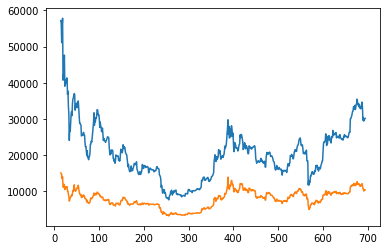

In [54]:
plt.plot(CRIX_future.price)
plt.plot(CRIX_future.Close)

In [55]:
CRIX_future = CRIX_future.loc[:,['date', 'price', 'Close']] 
CRIX_future.columns = ['date', 'CRIX', 'future']
CRIX_future.set_index('date', inplace=True)

In [194]:
CRIX_price = CRIX_future.CRIX
future_price = CRIX_future.future

In [72]:
CRIX_future_logreturns = np.log(CRIX_future/CRIX_future.shift(1))

In [152]:
from statsmodels.distributions.empirical_distribution import ECDF

CRIX = CRIX_future_logreturns.iloc[:,0]
future = CRIX_future_logreturns.iloc[:,1]
u = ECDF(future)(future)
u = pd.Series(u, index=future.index)[1:]
v = ECDF(CRIX)(CRIX)
v = pd.Series(v, index=CRIX.index)[1:]

Text(0, 0.5, 'CRIX quantile level')

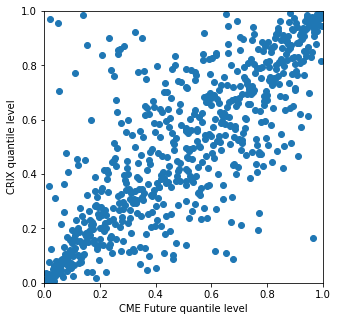

In [153]:
plt.figure(figsize=(5,5))
plt.scatter(u,v)
plt.xlim((0,1))
plt.ylim((0,1))
plt.xlabel('CME Future quantile level')
plt.ylabel('CRIX quantile level')

In [167]:
list(u.index.strftime('%Y-%m-%d'))

['2018-01-09',
 '2018-01-10',
 '2018-01-11',
 '2018-01-12',
 '2018-01-16',
 '2018-01-17',
 '2018-01-18',
 '2018-01-19',
 '2018-01-22',
 '2018-01-23',
 '2018-01-24',
 '2018-01-25',
 '2018-01-26',
 '2018-01-29',
 '2018-01-30',
 '2018-01-31',
 '2018-02-01',
 '2018-02-02',
 '2018-02-05',
 '2018-02-06',
 '2018-02-07',
 '2018-02-08',
 '2018-02-09',
 '2018-02-12',
 '2018-02-13',
 '2018-02-14',
 '2018-02-15',
 '2018-02-16',
 '2018-02-20',
 '2018-02-21',
 '2018-02-22',
 '2018-02-23',
 '2018-02-26',
 '2018-02-27',
 '2018-02-28',
 '2018-03-01',
 '2018-03-02',
 '2018-03-05',
 '2018-03-06',
 '2018-03-07',
 '2018-03-08',
 '2018-03-09',
 '2018-03-12',
 '2018-03-13',
 '2018-03-14',
 '2018-03-15',
 '2018-03-16',
 '2018-03-19',
 '2018-03-20',
 '2018-03-21',
 '2018-03-22',
 '2018-03-23',
 '2018-03-26',
 '2018-03-27',
 '2018-03-28',
 '2018-04-02',
 '2018-04-03',
 '2018-04-04',
 '2018-04-05',
 '2018-04-06',
 '2018-04-09',
 '2018-04-10',
 '2018-04-11',
 '2018-04-12',
 '2018-04-13',
 '2018-04-16',
 '2018-04-

In [177]:
import plotly.express as px

df = pd.DataFrame({'u':u, 'v':v, 'Date':list(u.index.strftime('%Y-%m-%d'))})
fig = px.scatter(df, x='u', y='v', hover_data=['Date'])
fig.show()

In [210]:
df = pd.DataFrame({'CRIX':CRIX_price,
                   'future':future_price, 
                   'Date':list(CRIX.index.strftime('%Y-%m-%d'))})

fig = px.line(df.iloc[1:,:], x= 'Date', y='future')
fig.add_scatter(x= df.iloc[1:,-1], y=df.iloc[1:,0], name='CRIX')
fig.add_scatter(x= df.iloc[1:,-1], y=df.iloc[1:,1], name='future')

# px.line(df.iloc[1:,:], x='Date', y='future')

In [214]:
df = pd.DataFrame({'CRIX':CRIX,
                   'future':future, 
                   'Date':list(CRIX.index.strftime('%Y-%m-%d'))})

fig = px.line(df.iloc[1:,:], x= 'Date', y='future')
fig.add_scatter(x= df.iloc[1:,-1], y=df.iloc[1:,0], name='CRIX')
fig.add_scatter(x= df.iloc[1:,-1], y=df.iloc[1:,1], name='future')

# px.line(df.iloc[1:,:], x='Date', y='future')

Text(0, 0.5, 'CRIX')

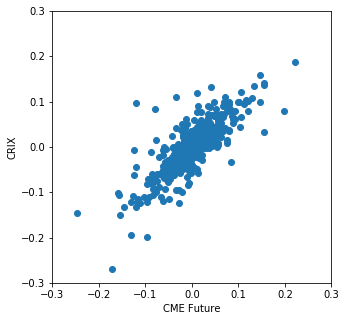

In [91]:
plt.figure(figsize=(5,5))
plt.scatter(future,CRIX)
plt.xlim((-0.3,0.3))
plt.ylim((-0.3,0.3))
plt.xlabel('CME Future')
plt.ylabel('CRIX')

Optimization terminated successfully.
         Current function value: -0.619267
         Iterations: 71
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: 0.007944
         Iterations: 66
         Function evaluations: 139


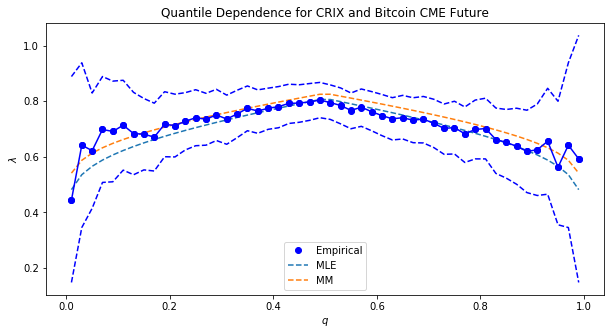

In [128]:
plt.figure(figsize=(10,5))
plt.plot(q_arr, L, 'bo', label='Empirical')

C = Gaussian_Mix_Independent({'rho':0.9, 'p':0.9}, stats.uniform, stats.uniform)

C.canonical_calibrate(u,v)
L_C = np.array([C._lambda(q) for q in q_arr])
L = np.array([empirical_lambda(u,v,q) for q in q_arr])

plt.plot(q_arr, L_C, '--', label="MLE")

C = Gaussian_Mix_Independent({'rho':0.9, 'p':0.9}, stats.uniform, stats.uniform)
C.mm_calibrate(u,v,[0.05,0.1,0.9,0.95])
L_C = np.array([C._lambda(q) for q in q_arr])
plt.plot(q_arr, L_C, '--', label="MM")

LQ = np.quantile(np.array(L_arr), 0.05, axis=0)
UQ = np.quantile(np.array(L_arr), 0.95, axis=0)
plt.plot(q_arr, LQ , 'b--')
plt.plot(q_arr, np.quantile(np.array(L_arr), 0.5, axis=0), 'b-o')
plt.plot(q_arr, UQ, 'b--')
plt.title('Quantile Dependence for CRIX and Bitcoin CME Future')
plt.ylabel(r'$\lambda$')
plt.xlabel(r'$q$')
plt.legend()

In [80]:
from copulae1 import *

In [94]:
# Gaussian, t_Copula, Clayton, Frank, Gumbel, Plackett, Gaussian mix Indep
C1  = Gaussian(dict(rho=0.9),       Law_RS=stats.norm, Law_RF=stats.norm) # fix the maringals!
C2  = t_Copula(dict(rho=0.1, nu=4), Law_RS=stats.norm, Law_RF=stats.norm, nu_lowerbound=2)
C2c = t_Copula(dict(rho=0.1, nu=4), Law_RS=stats.norm, Law_RF=stats.norm, nu_lowerbound=4)
C3  = Clayton(dict(theta=0.1),      Law_RS=stats.norm, Law_RF=stats.norm)
C4  = Frank(dict(theta=0.1),        Law_RS=stats.norm, Law_RF=stats.norm)
C5  = Gumbel(dict(theta=3),         Law_RS=stats.norm, Law_RF=stats.norm)
C6  = Plackett(dict(theta=10),      Law_RS=stats.norm, Law_RF=stats.norm)
C7  = Gaussian_Mix_Independent(dict(rho=.5,p=0.7),Law_RS=stats.norm, Law_RF=stats.norm)
Copulae_names = ['Gaussian', 't_Copula', 't_Copula_Capped', 'Clayton', 'Frank', 'Gumbel', 'Plackett', 'Gauss Mix Indep']
Copulae_arr   = [C1,C2,C2c,C3,C4,C5,C6,C7]
Copulae = dict(zip(Copulae_names, Copulae_arr))


In [96]:
paras = []
likelihood = []
calibration_method = "MLE"
for C_name in Copulae:
    if calibration_method == "MLE":
        Copulae[C_name].canonical_calibrate(u, v)

    elif calibration_method == "MM":
        Copulae[C_name].mm_calibrate(u, v, q_arr)

    print(C_name, 'is done.\n')

for C_name in Copulae:
    paras.append((C_name, Copulae[C_name].paras))

for C_name in Copulae:
    ln = Copulae[C_name].dependency_likelihood(u, v)
    likelihood.append((C_name, ln))

Optimization terminated successfully.
         Current function value: -0.517357
         Iterations: 33
         Function evaluations: 71
Gaussian is done.

Optimization terminated successfully.
         Current function value: -0.631462
         Iterations: 177
         Function evaluations: 343
t_Copula is done.

Optimization terminated successfully.
         Current function value: -0.618307
         Iterations: 146
         Function evaluations: 281
t_Copula_Capped is done.

Optimization terminated successfully.
         Current function value: -0.501729
         Iterations: 43
         Function evaluations: 91
Clayton is done.

Optimization terminated successfully.
         Current function value: -0.509684
         Iterations: 47
         Function evaluations: 105
Frank is done.

Optimization terminated successfully.
         Current function value: -0.555123
         Iterations: 35
         Function evaluations: 78
Gumbel is done.

Optimization terminated successfully.
        

In [97]:
from toolbox import *

In [99]:
best_h = []
for C in Copulae_arr:
    best_h.append(optimize_h(C, [10], [0.05,0.01], [0.05,0.01]))

Optimization terminated successfully.
         Current function value: 0.350657
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.891585
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 1.222202
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 1.577958
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.974360
         Iterations: 15
         Function evaluations: 33
Optimization terminated successfully.
         Current function value: 1.377243
         Iterations: 13
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.530010
         Iterations: 13
         Function evaluations: 26
Optimization terminated successful

/Users/francis/Google Drive/00_IRTG1792/copula/Py_notebooks/toolbox.py:288: RuntimeWarning: invalid value encountered in power
  part2 = np.sin(self.alpha*(U+xi))/(np.cos(U)**(1/self.alpha))
/Users/francis/Google Drive/00_IRTG1792/copula/Py_notebooks/toolbox.py:289: RuntimeWarning: invalid value encountered in power
  part3 = (np.cos(U-self.alpha*(U+xi))/W )**((1-self.alpha)/self.alpha)


Optimization terminated successfully.
         Current function value: 0.351535
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.943754
         Iterations: 12
         Function evaluations: 24
Optimization terminated successfully.
         Current function value: 1.365089
         Iterations: 12
         Function evaluations: 24
Optimization terminated successfully.
         Current function value: 1.898102
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 1.015618
         Iterations: 12
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 1.577357
         Iterations: 12
         Function evaluations: 25
Optimization terminated successfully.
         Current function value: 0.361947
         Iterations: 13
         Function evaluations: 26
Optimization terminated successful

In [101]:
best_h = pd.DataFrame(best_h)
best_h.columns = ['Variance', 'ERM k=10', 'ES q=0.05', 'ES q=0.01',
                  'VaR q=0.05', 'VaR q=0.05']
best_h.index = Copulae_names

In [104]:
best_h

,Variance,ERM k=10,ES q=0.05,ES q=0.01,VaR q=0.05,VaR q=0.05
Gaussian,0.805469,0.804980,0.802344,0.802246,0.800781,0.800391
t_Copula,0.801855,0.809863,0.733398,0.534863,0.847852,0.668457
t_Copula_Capped,0.837305,0.826172,0.766504,0.639160,0.837402,0.711719
Clayton,0.730273,0.638379,0.594238,0.538184,0.674902,0.581836
Frank,0.778809,0.780371,0.786523,0.791895,0.783496,0.798242
Gumbel,0.804980,0.883203,0.884473,0.833398,0.918652,0.869043
Plackett,0.798730,0.796094,0.742383,0.628320,0.819531,0.704492
Gauss Mix Indep,0.774609,0.783398,0.656836,0.411230,0.871094,0.532422


In [106]:
for C in Copulae_arr:
    print(C.paras)

{'rho': 0.8057913513667885}
{'rho': 0.8207434167533371, 'nu': 2.0000000000001075}
{'rho': 0.8431669689726538, 'nu': 4.000000000000036}
{'theta': 2.455685081481943}
{'theta': 8.48274505674842}
{'theta': 2.5375249385833727}
{'theta': 27.897995561128482}
{'rho': 0.9101658078062873, 'p': 0.8517502499097913}


/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


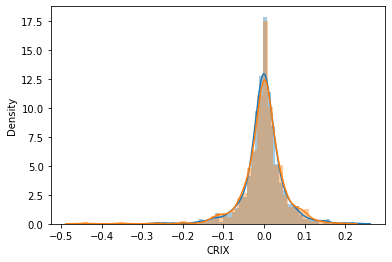

In [108]:
sns.distplot(future)
sns.distplot(CRIX)